<center><h1>Wine Tasting Data (UCI, 2015)</h1> <br>
This dataset was downloaded from the UCI Machine Learning Repository.</center>

In [3]:
# Import math, visuals, sklearn models, metrics and validation tools.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Show figures inline.
%matplotlib inline

# Customize some of the plotting defaults.
rc={'figure.figsize':(10,10),"font.size":25,"axes.titlesize":25,"axes.labelsize":20}
sns.set(font_scale=2,rc=rc,style="white",context='notebook')

## Exploratory Data Analysis (EDA)

Read in the data and describe the columns.

In [4]:
df = pd.read_csv('winequalityN.csv')
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Deal with rows containing missing values. We can interpolate/impute values or remove observations altogether if the number of inconsistent rows is small relative to the entire set.


In [5]:
n = df[df.isnull().values == True].shape[0]
bad_row_frac = round(n/float(df.shape[0]),2)
print "There are {} rows (~ {}% of data) with at least one missing cell.".format(n,bad_row_frac)

# Should we remove them?
thresh = 0.03 # 3% threshold, arbitrarily chosen.
if bad_row_frac < thresh:
    print "Removing rows with missing values..."
    df.drop(df[df.isnull().values == True].index,inplace=True)

There are 38 rows (~ 0.01% of data) with at least one missing cell.
Removing rows with missing values...


There are almost exactly 3 times as many white wines as red in the data. 

### Plot 1a: Pairplot of All Variables

Red wine is displayed as RED and white as GREEN (white markers would be difficult!)

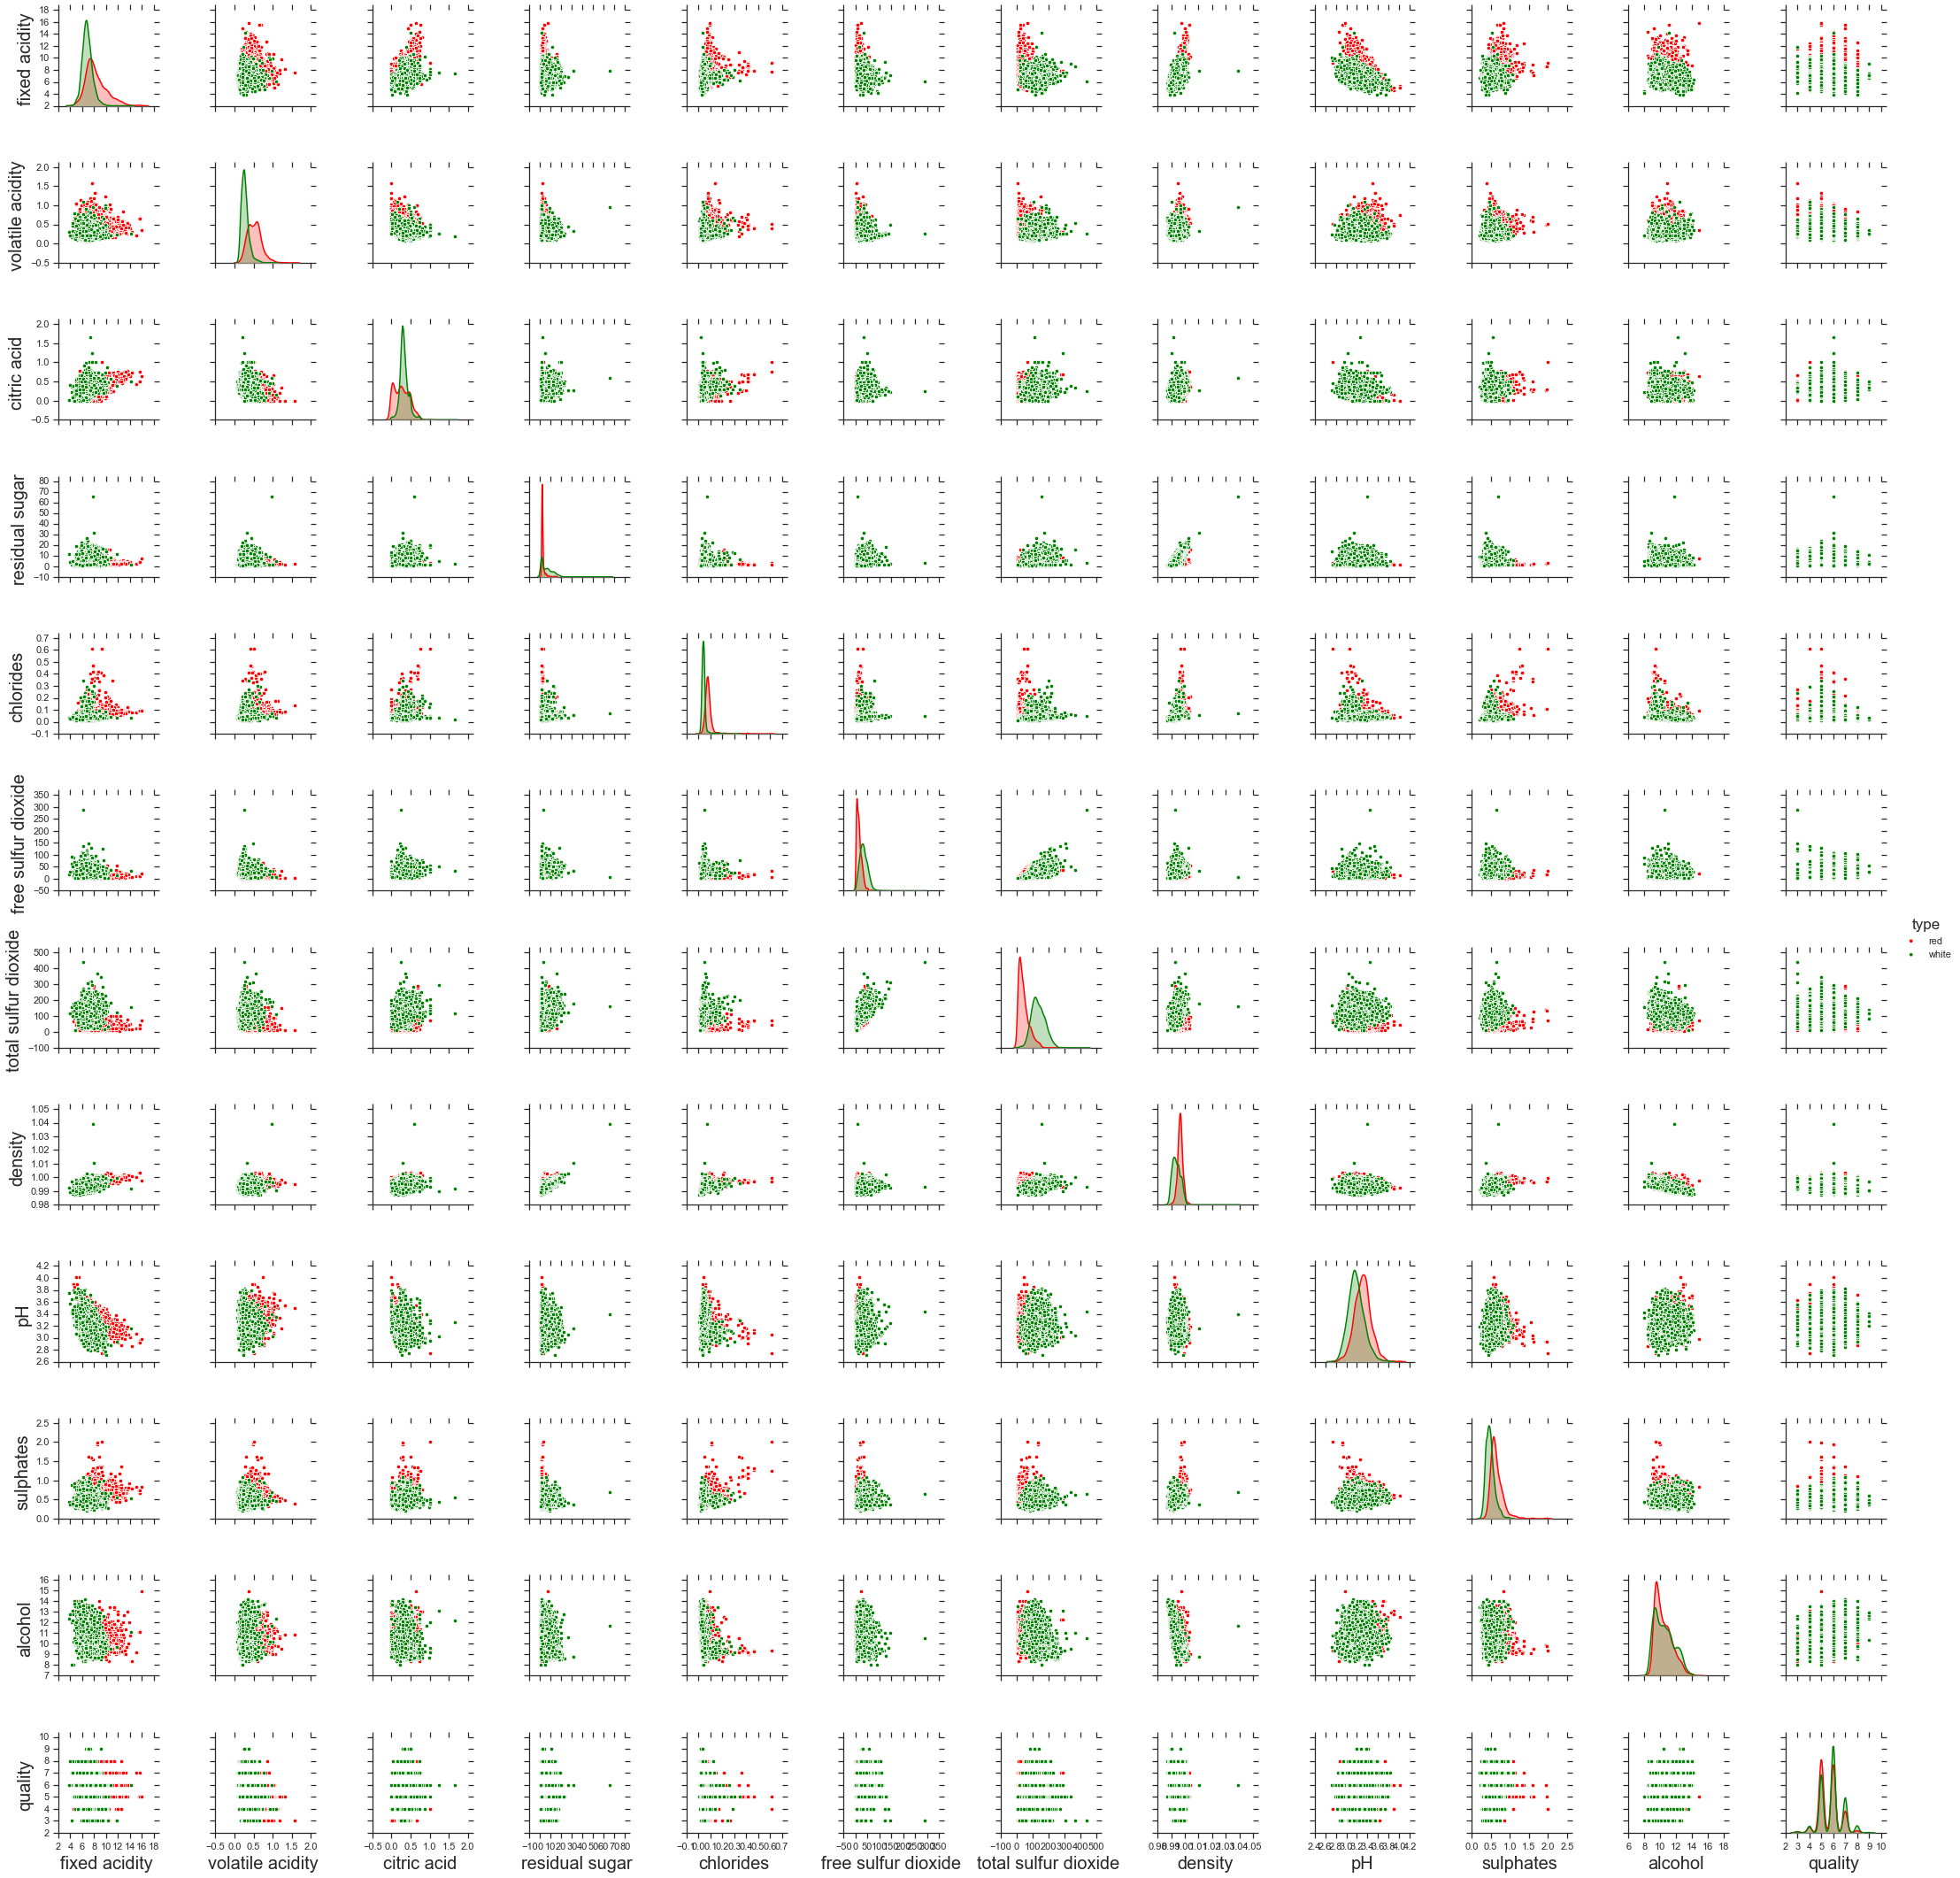

In [22]:
sns.pairplot(df,hue='type',hue_order=['red','white'],palette=['red','green'])

There appear to be obvious visual differences in physical and chemical properties between red and white wine populations. What constitutes a red or white wine, chemically? This could be an interesting analysis question. Let's also make a heatmap to see correlation numbers to begin feature selection.

### Plot 1b: Heatmap of All Variables

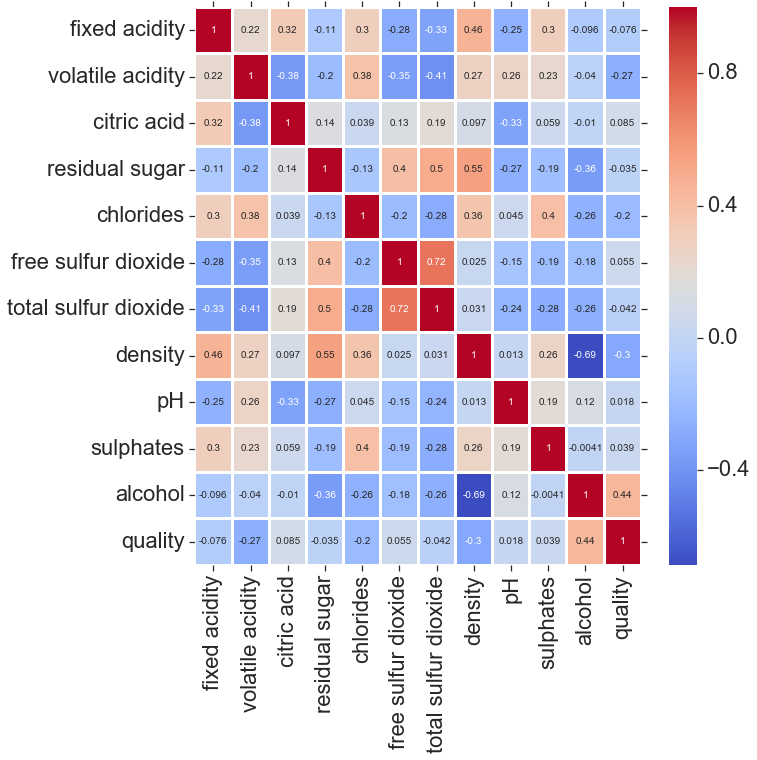

In [6]:
plt.figure(figsize=[10,10],dpi=2000)
sns.heatmap(df.corr(),cmap='coolwarm',linewidth=2,annot=True,annot_kws={'fontsize':10})

From the above two correlation plots, some noteworthy correlations are:

* Density vs. Alcohol (negative), Residual Sugar or Fixed Acidity (positive). 
    * Alcohol is less dense than water, therefore higher alcohol = lower density, holding all else constant
    * Residual sugar is denser than water. Higher sugar = higher density, holding all else constant
    * Acids are generally denser than water
* pH vs. any type of acid 
    * the pH is a directly dependent on the relative amounts of each acid, which each have their own pH
* Free and Total Sulfur Dioxide
    * One comprises the other
* Quality vs. Alcohol (positive)
* Quality vs. Density (negative)
    * But recall ALCOHOL and DENSITY are themselves correlated physically (negatively)
    * Therefore Quality is likely related to ALCOHOL and this confounds the relation with density
* Quality vs. Volatile Acidity (negative)
    * It's called volatile acidity for a reason! Generally associated with a "poor nose" to the wine

### Comparison of Red and White Wine Sample Predictors

Let's look at the differences between the red and white wine sample populations.

Number of red wines = 1593
Number of white wines = 4870


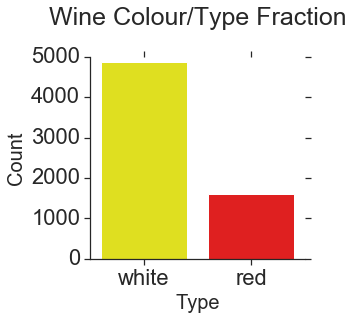

In [10]:
# Make copies for red and white datasets.
red,white = df[df['type']=='red'],df[df['type']=='white']

fig,ax = plt.subplots(1,figsize=[5,5])
sns.despine()
sns.countplot(x='type',data=df,ax=ax,palette=['yellow','red'])
#ax.annotate(s='~{:3.0f}% are RED\n~{:3.0f}% are WHITE'.format(100*float(len(red))/len(df),100*float(len(white))/len(df)),
#           xy=(0.6,0.6),xycoords='figure fraction')
ax.set(ylabel='Count',xlabel='Type')
ax.set_title('Wine Colour/Type Fraction\n')
plt.tight_layout()

# How many of each type of wine are, red and white?
for wine in ['red','white']:
    print "Number of {} wines = {}".format(wine,len(df[df['type']==wine]))

### Plot 2: Boxplot Distributions of All Predictors (Split by Red, White)
How different are the predictor distributions for each wine type?

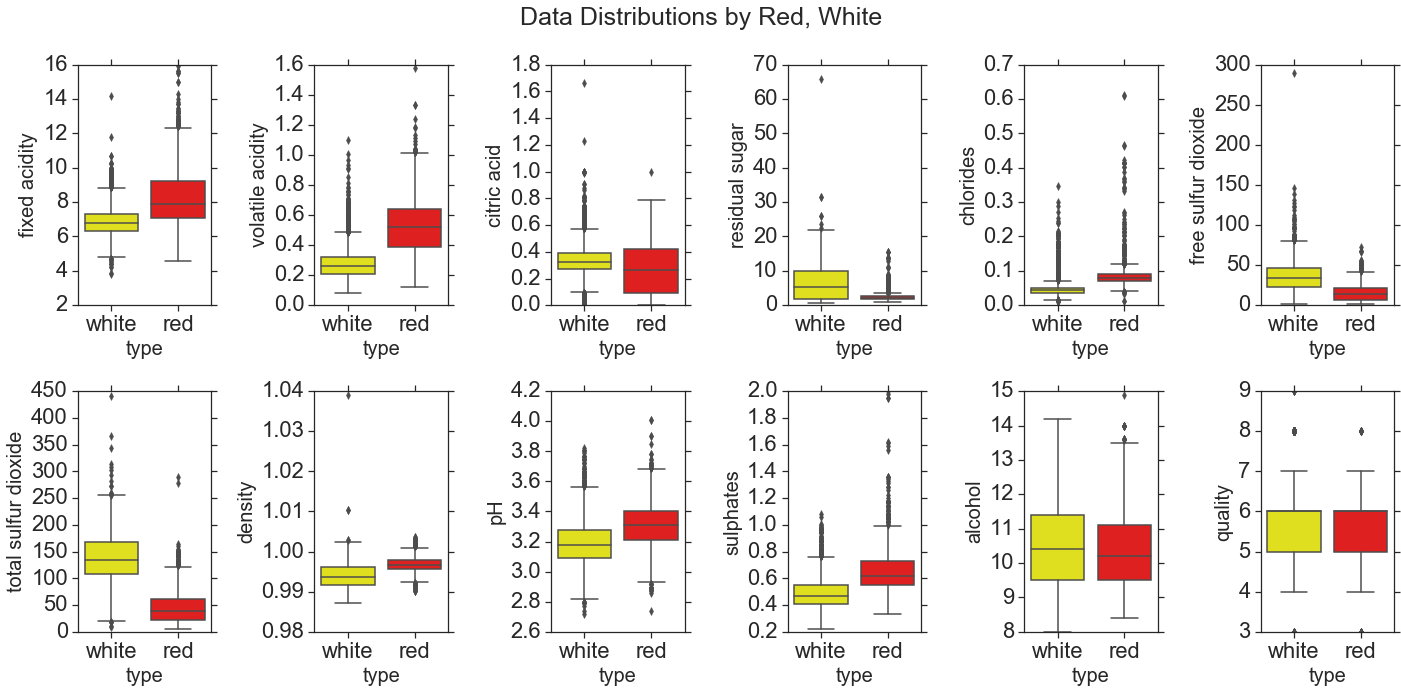

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=6,figsize=[20,10])
columngrid = np.array(df.columns[df.columns!='type']).reshape(2,6)
fig.suptitle('Data Distributions by Red, White')

for i,column in enumerate(df.columns[df.columns!='type']):
    ind1,ind2 = np.where(columngrid==column)
    ind1,ind2=ind1[0],ind2[0]
    sns.boxplot(x='type',y=column,data=df,ax=axes[ind1,ind2],palette=['yellow','red'])
    #axes[ind1,ind2].set_title(column+'\n',fontsize=25)
plt.tight_layout()
fig.subplots_adjust(top=0.9)

This grid displays the "fingerprint" of both red and white wine samples. . Visually it appears red and white wines differ in most categories and are only similar in the quality ratings and the alcohol content. 

Red wines are characterized apart from white wines by:
    - Larger FIXED ACIDITY, VOLATILE ACIDITY, CHLORIDES, pH, SULPHATES, DENSITY
    - Lower CITRIC ACID, RESIDUAL SUGAR, FREE and TOTAL SULFUR DIOXIDE

Notably, _the quality of the wine is independent of the type of wine_.

** Student's T-test for Significant Differences of Mean Predictor Values in Red, White Wine**  
Group by colour/type and show the mean of each aggregate variable.

In [26]:
df.groupby('type').mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
type,,,,,,,,,,,,
red,8.326365,0.527659,0.271551,2.538512,0.087497,15.841808,46.463905,0.996752,3.310590,0.657866,10.419617,5.636535
white,6.855123,0.278071,0.334199,6.394343,0.045771,35.317146,138.340144,0.994026,3.188154,0.489700,10.516772,5.878029


In [66]:
# Initialize dataframe for t, p statistics outputs with index as each attribute save type.
tdf=pd.DataFrame(index=[colname for colname in df.columns[df.columns!='type']])
t,p,sig=[],[],[]
for colname in df.columns[df.columns!='type']: # type is a string and we've grouped by it.
    alpha = 0.05 # significance tolerance.
    t2, p2 = stats.ttest_ind(red[colname],white[colname],equal_var=False) # Welch's 2-sided t-test.
    t.append(t2)
    p.append(p2)
    if p2<alpha:
        sig.append(True)
    else:
        sig.append(False)
# Assign columns.
tdf['t'],tdf['p'],tdf['Significant?'] = t,p,sig
tdf.T

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
t,32.5091,52.906,-12.094,-47.7096,34.1533,-54.4774,-89.6291,42.6894,27.6396,36.9091,-3.03673,-10.1098
p,1.26923e-183,0,1.49346e-32,0,5.43238e-198,0,0,0,4.94218e-148,6.71928e-230,0.00241153,1.21098e-23
Significant?,True,True,True,True,True,True,True,True,True,True,True,True


Although all differences in means between red and white are statistically significant, this does not mean that the differences are IMPORTANT to us. For example, the fractional differences between the means in QUALITY is incredibly small (2%), so this doesn't really reflect a large enough difference for us to care. However, mean values of predictors like total sulfur dioxide are not only statistically different by the t-test but almost importantly different for the fractional difference is quite large (~50%).

## Can we CLASSIFY wine as RED or WHITE?  
### Model I: Logistic Classifier of Wine Type (Colour)

How accurately can we classify the type of wine given its predictors? Let's build a simple model that classifies the colour of the wine. Given the obvious visual differences in predictor distributions in Plot 2 by colour, **the classes appear significantly recognizable and a simple and accurate classifier seems plausible.**

In [173]:
# Initialize train and test sets of 80% and 20% of the data respectively.
X,y = df.drop('type',axis=1),df['type']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# Train a logistic model on the training data.
logmodel = LogisticRegression(class_weight='balanced')
logmodel.fit(X_train,y_train)

# Print the coefficients of the above model.
print("\nLogistic Regression Coefficients:\n")
pd.DataFrame.from_records(zip(df.columns[df.columns!='type'],logmodel.coef_[0]),columns=['Predictor','Coef']).T


Logistic Regression Coefficients:



,0,1,2,3,4,5,6,7,8,9,10,11
Predictor,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Coef,-0.595482,-8.71978,0.322129,0.119324,-2.83026,-0.0380846,0.059131,3.52416,-2.49419,-6.8214,0.637695,0.163022


**Estimate the TEST ERROR of the model using 5-Fold Cross Validation.**

In [175]:
k = 5
cv = KFold(len(X_train),n_folds=k,shuffle=True)
log_accuracy = cross_val_score(logmodel, X_train, y_train, cv=cv).mean()
print "\nEstimate Test Error With {}-Fold CV = {:.2f}%".format(k,100*log_accuracy)


Estimate Test Error With 5-Fold CV = 97.74%


**Predict the wine colours of the testing dataset (1293 samples) and show a confusion matrix, ROC curve.**


Classification Report:

             precision    recall  f1-score   support

        red       0.89      0.98      0.93       278
      white       0.99      0.97      0.98      1015

avg / total       0.97      0.97      0.97      1293



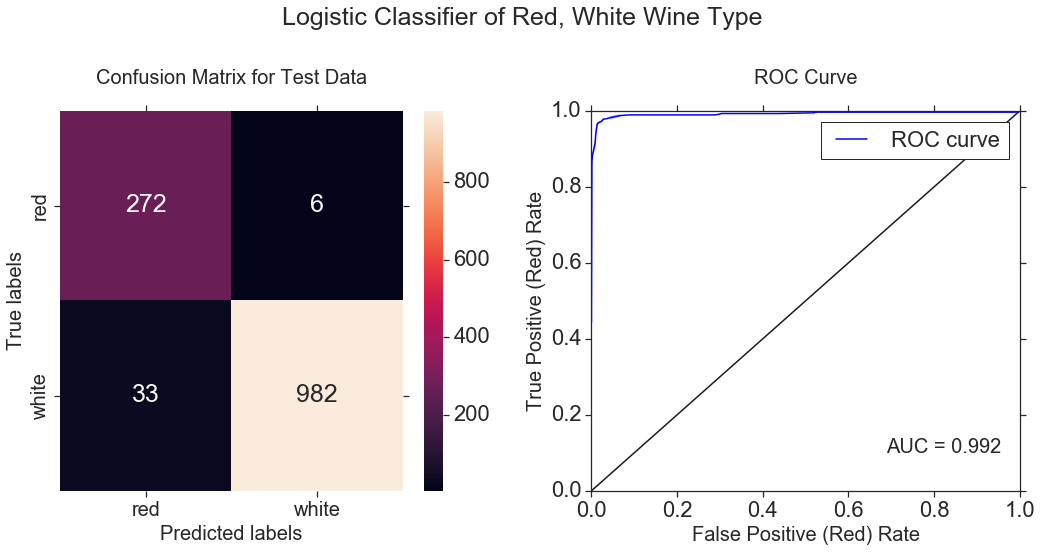

In [183]:
# Make predictions with model on the test data (20% of original dataset).
predictions = pd.Series(cross_val_predict(logmodel,X=X_test,y=y_test))
print("\nClassification Report:\n")
print(classification_report(y_test,predictions))

# Confusion Matrix on Test Data and ROC Curve.
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=[15,8])
fig.suptitle('Logistic Classifier of Red, White Wine Type')
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='g',cbar_kws={'cmap':'coolwarm'},ax=axes[0])
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('True labels')
axes[0].set_title('Confusion Matrix for Test Data\n',fontsize=20)
axes[0].xaxis.set_ticklabels(['red', 'white'],fontsize=20)
axes[0].yaxis.set_ticklabels(['red', 'white'],fontsize=20)

# Construct ROC curve, print AUC (area under curve).
prob_red = np.array([i for i,j in logmodel.predict_proba(X_test)]) # returns probability of being red, ordered like logmodel.classes_
fpr, tpr, thresholds = roc_curve(y_test.map(lambda x: 1 if x=='red' else 0),prob_red,pos_label=1)
roc_auc = auc(fpr, tpr)
sns.lineplot(x=fpr,y=tpr,color='blue',ax=axes[1],label='ROC curve')
sns.lineplot(x=fpr,y=fpr,ax=axes[1],color='k')
axes[1].annotate(s='AUC = {}'.format(roc_auc.round(3)),xy=(0.85,0.18),xycoords='figure fraction',fontsize=20)
axes[1].set_xlabel('False Positive (Red) Rate')
axes[1].set_ylabel('True Positive (Red) Rate')
axes[1].set_title('ROC Curve\n',fontsize=20)

# Adjust plot layout.
plt.tight_layout()
plt.subplots_adjust(top=0.8)

### **THE GIST: red and white wine samples are fairly easy to identify chemically (ie. there are large distances between group clusters in parameter space) and are only erroneously classified about 2% of the time.**

From the above, it was fairly easy to predict a red or white wine given the predictors available. Without much thought as to feature selection or even flexibility beyond a linear logistic class separator this classifier produced a ~2% error rate. The worst we could do is to guess a constant classifier of white wine which produces an error rate of 9% (red comprises 9% of the dataset). Our fairly naive classifier is already \better by ~7% accuracy. The area under the ROC curve (AUC) is 0.992, therefore for any tuning of false or true positive rates while keeping a low classification error will always be highly accurate.

## Can we CLASSIFY wine as GOOD or BAD?
### Model II: Logistic Classifier of Wine Quality 

Let's classify the data by separating out wines with quality ratings of:

    - [8-10] : 'good' 
    - [4-7]  : 'mid'
    - [0-3]  : 'bad'
    
This was chosen arbitrarily by myself, but in reality 

How many are good or bad, and are they predominantly red or white?

In [188]:
df['Quality Class'] = 'mid'
df.loc[df['quality']>=8,'Quality Class'] = 'good'
df.loc[df['quality']<=3,'Quality Class'] = 'bad'

good, bad = df[df['quality']>=8],df[df['quality']<=3]

print("Dataset comprised of:\n{:3.0f}% are RED\n{:3.0f}% are WHITE\n".format(100*float(len(red))/len(df),100*float(len(white))/len(df)))
print("Of the {} GOOD wines:\n{:4.0f}% are RED\n{:4.0f}% are WHITE\n".format(len(good),100*float(len(good[good['type']=='red']))/len(good),100*float(len(good[good['type']!='red']))/len(good)))
print("Of the {} BAD wines:\n{:4.0f}% are RED\n{:4.0f}% are WHITE".format(len(bad),100*float(len(bad[bad['type']=='red']))/len(bad),100*float(len(bad[bad['type']!='red']))/len(bad)))

Dataset comprised of:
 25% are RED
 75% are WHITE

Of the 197 GOOD wines:
   9% are RED
  91% are WHITE

Of the 30 BAD wines:
  33% are RED
  67% are WHITE


There exists a larger fraction of GOOD wines that are WHITE than the actual population fraction of whites (75%), and a larger fraction of BAD wines that are RED than the actual fraction of reds (25%). 

### Plot: All Predictors  vs. Quality Class 
How different are the predictor distributions for each wine type? Each of these plots will show any trends that exist between bad and good wines in general, independent of the wine colour.

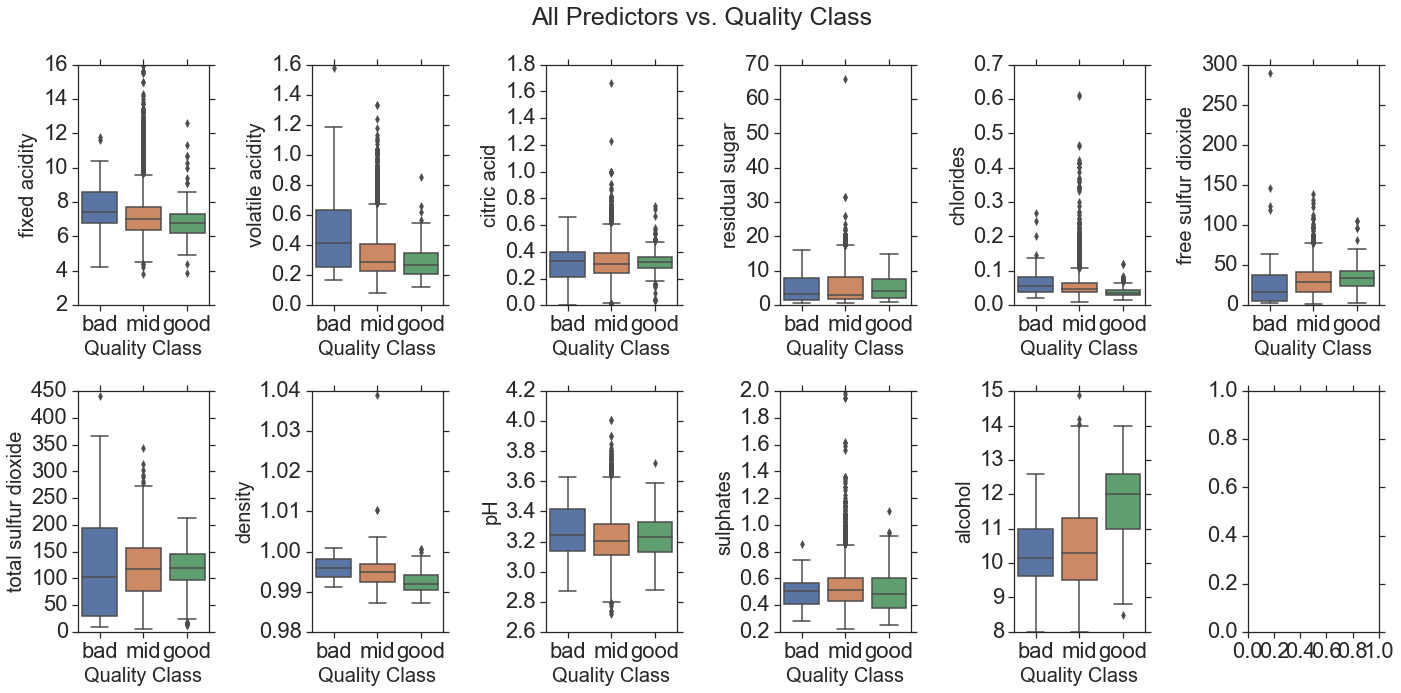

In [195]:
fig, axes = plt.subplots(nrows=2,ncols=6,figsize=[20,10])
fig.suptitle('All Predictors vs. Quality Class')
columngrid = np.array(df.columns.drop(['type','Quality Class'])).reshape(2,6)

for i,column in enumerate(df.columns.drop(['type','Quality Class','quality'])):
    ind1,ind2 = np.where(columngrid==column)
    ind1,ind2=ind1[0],ind2[0]
    sns.boxplot(x='Quality Class',y=column,data=df,ax=axes[ind1,ind2],order=['bad','mid','good'])
plt.tight_layout()
plt.subplots_adjust(top=0.9)

The above plots are of Quality Class vs. Predictor trends for both types, but there are ~3x more white wine samples as red. Therefore these trends are heavily weighted towards the trends of white wine, and we should stratify this plot by colour for a better interpretation.

### Plot: Quality Class vs. All Predictors, Stratified by Colour/Type
Repeat the same as above, except stratify by the colour.

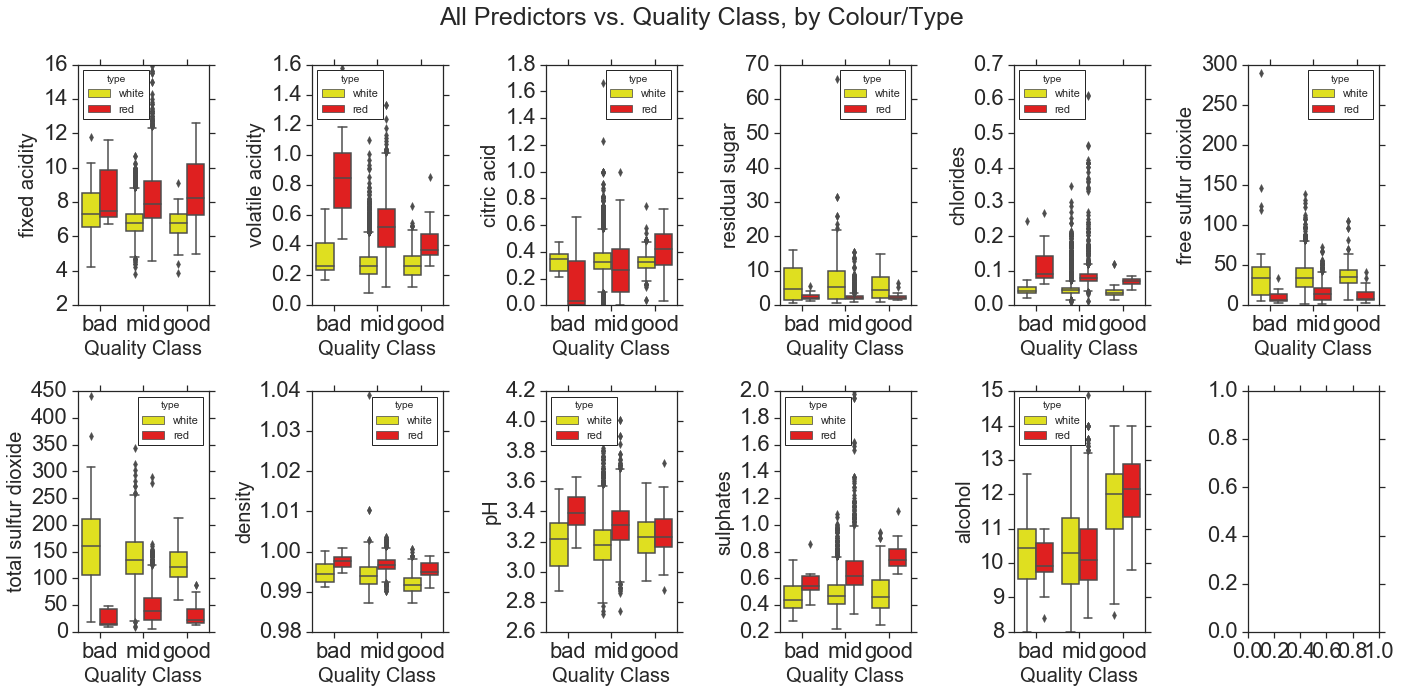

In [202]:
fig, axes = plt.subplots(nrows=2,ncols=6,figsize=[20,10])
fig.suptitle('All Predictors vs. Quality Class, by Colour/Type')
columngrid = np.array(df.columns.drop(['type','Quality Class'])).reshape(2,6)

with sns.plotting_context("notebook"):
    for i,column in enumerate(df.columns.drop(['type','Quality Class','quality'])):
        ind1,ind2 = np.where(columngrid==column)
        ind1,ind2=ind1[0],ind2[0]
        sns.boxplot(x='Quality Class',y=column,data=df,ax=axes[ind1,ind2],order=['bad','mid','good'],hue='type',palette=['yellow','red'])
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)

Here we see that colour plays a key role in trend interpretation. Sulphates vs. quality class in 3a indicates a non-trend across colour. Plot 3b shows the red samples trend positively with amount of sulphates, but this is masked in 3a due to red presence in the data of only 25%. This motivates us to split the data by colour permanently and describe wine sample properties specific to their colour.

Keeping in mind that each trend is interpreted _with all other variables held constant_, the takeaways from each of the above plots, in order:

    - FIXED ACIDITY is not a strong predictor of quality
    - Red wine quality is higher with less VOLATILE ACIDITY, CHLORIDES, more CITRIC ACID, SULPHATES
    - White wine is not significantly affected by VOLATILE ACIDITY, CITRIC ACID, CHLORIDES, SULPHATES
    - RESIDUAL SUGAR has no impact on quality rating across both colours
    - Red wine is better when more acidic (lower pH), white wine quality is independent of pH
    - The BEST RED AND/OR WHITE WINES HAVE THE HIGHEST ALCOHOL CONTENT (~2% higher than wines rated below 8)
    
And remember our conclusions about properties of red and white wines in general:

    - REDS have larger FIXED ACIDITY, VOLATILE ACIDITY, CHLORIDES, pH, SULPHATES, DENSITY than WHITES
    - REDS have lower CITRIC ACID, RESIDUAL SUGAR, FREE and TOTAL SULFUR DIOXIDE than WHITES

**Logistic Regression for Classification of Wine Quality**



Logistic Regression Coefficients:

               Predictor      Coef
0          fixed acidity -0.501753
1       volatile acidity -1.887438
2            citric acid  0.589174
3         residual sugar  0.110593
4              chlorides -0.027463
5    free sulfur dioxide -0.000958
6   total sulfur dioxide -0.006378
7                density -0.033141
8                     pH -0.806609
9              sulphates  0.670250
10               alcohol  0.750385
11                 white  0.285591

Model Accuracy or Estimate Test Error (via 5-Fold CV) = 88.948949%

Classification Report:

             precision    recall  f1-score   support

        bad       0.43      0.50      0.46         6
       good       0.92      0.90      0.91        40

avg / total       0.86      0.85      0.85        46

Confusion Matrix:



[<matplotlib.text.Text at 0x11476b1d0>, <matplotlib.text.Text at 0x1146a94d0>]

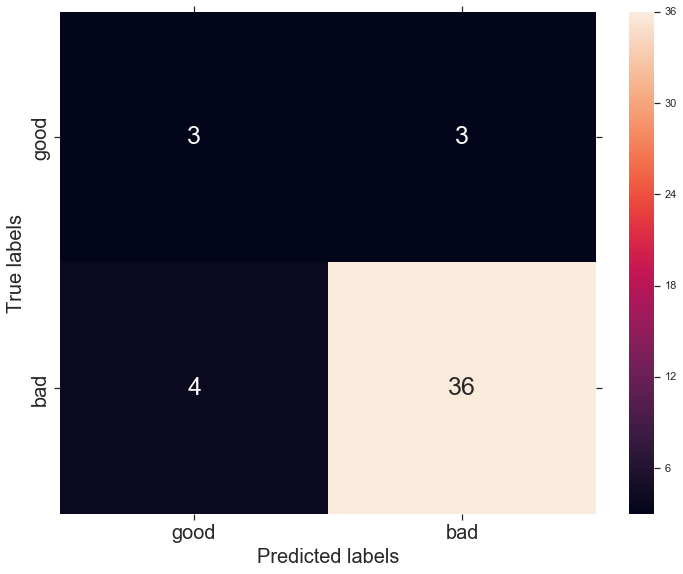

In [32]:
# Convert wine type to dummies.
dums = pd.get_dummies(df['type'],drop_first=True)
df = pd.concat([df,dums],axis=1)
good_or_bad = df[df['Quality Class']!='mid'].copy()

# Split into training and testing sets.
X,y = good_or_bad.drop(['type','quality','Quality Class'],axis=1),good_or_bad['Quality Class']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# Train logistic model on training set.
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

# Print the coefficients of the model fitted on the training set.
print("\nLogistic Regression Coefficients:\n")
print(pd.DataFrame.from_records(zip(X.columns,logmodel.coef_[0]),columns=['Predictor','Coef']))

# Estimate the test-error using K-Fold Cross Validation.
cv = KFold(len(X_train),n_folds=5,shuffle=True)
log_accuracy = cross_val_score(logmodel, X_train, y_train, cv=cv).mean()
print "\nModel Accuracy or Estimate Test Error (via 5-Fold CV) = {:.6f}%".format(100*log_accuracy)

# Classify the testing data X_test, y_test and see accuracy report.
predictions = cross_val_predict(logmodel,X=X_test,y=y_test)
print("\nClassification Report:\n")
print(classification_report(y_test,predictions))
print("Confusion Matrix:\n")
fig,ax=plt.subplots(1)
sns.heatmap(confusion_matrix(y_test,predictions),annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['good', 'bad'],fontsize=20); ax.yaxis.set_ticklabels(['good', 'bad'],fontsize=20)

**KNN Classifier**

The optimal value of k is 4.

Model Accuracy or Estimate Test Error (via 10-Fold CV) = 85.833333%


/Users/reubengazer/anaconda/envs/astroconda/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 5 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


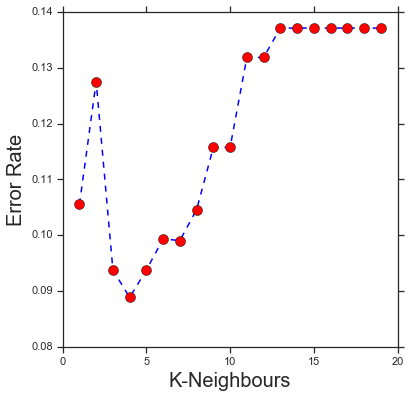

In [33]:
# Scale the predictors.
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X,y = good_or_bad.drop(['type','quality','Quality Class'],axis=1),good_or_bad['Quality Class']
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
X_feat = pd.DataFrame(scaled_features,columns=X.columns) # scaled X matrix of predictors.

# Produce a final validation set.
X_train,X_test,y_train,y_test = train_test_split(X_feat,y,test_size=0.2)

# Track accuracy of classifier (using 10-fold CV) for each value of k in carray cv_scores.
cv_scores = []
for k in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    scores = cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy')
    cv_scores.append(scores.mean())
    
# Compute optimal k, plot misclassification rate vs. k.
MSE = [1-x for x in cv_scores] # misclassification rate
optimal_k = range(1,20)[MSE.index(min(MSE))]
print("The optimal value of k is {}.".format(optimal_k))
    
# Plot error rate vs. choice of k-neighbours.
fig, ax = plt.subplots(1,figsize=[6,6])
ax.plot(range(1,20), MSE, color='blue', linestyle='--', marker='o', markerfacecolor='red', markersize=10)
ax.set_xlabel('K-Neighbours')
ax.set_ylabel('Error Rate')

# With optimal k chosen, perform fit and evaluate on the test data.
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn_accuracy = cross_val_score(knn,X_test,y_test,cv=10,scoring='accuracy').mean()
print "\nModel Accuracy or Estimate Test Error (via 10-Fold CV) = {:.6f}%".format(100*knn_accuracy)